# 2.1 Preparing the datasets

IMPORT THƯ VIỆN

In [1]:
!pip install ucimlrepo
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 2.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import export_graphviz
from matplotlib import pyplot as plt
from ucimlrepo import fetch_ucirepo
import graphviz
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns
import category_encoders as ce
import warnings

In [3]:
warnings.filterwarnings("ignore")

LẤY DỮ LIỆU

In [4]:
#Lấy dữ liệu từ https://archive.ics.uci.edu/dataset/15/breast+cancer+wisconsin+original
# fetch dataset
df = fetch_ucirepo(id=15)

# data (as pandas dataframes)
X = df.data.features
y = df.data.targets

# metadata
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Clump_thickness              699 non-null    int64  
 1   Uniformity_of_cell_size      699 non-null    int64  
 2   Uniformity_of_cell_shape     699 non-null    int64  
 3   Marginal_adhesion            699 non-null    int64  
 4   Single_epithelial_cell_size  699 non-null    int64  
 5   Bare_nuclei                  683 non-null    float64
 6   Bland_chromatin              699 non-null    int64  
 7   Normal_nucleoli              699 non-null    int64  
 8   Mitoses                      699 non-null    int64  
dtypes: float64(1), int64(8)
memory usage: 49.3 KB


In [5]:
columns_features = ['Clump_thickness','Clump_thickness','Uniformity_of_cell_shape','Marginal_adhesion','Single_epithelial_cell_size','Bare_nuclei','Bland_chromatin','Normal_nucleoli','Mitoses'] #loại các feature null nhiều
columns_target = ['Class']

df_features = X[columns_features]
df_target = y[columns_target]

CHIA TẬP DỮ LIỆU THEO CÁC TỈ LỆ

In [6]:
train_test_ratio = [(0.4, 0.6), (0.6, 0.4), (0.8, 0.2), (0.9, 0.1)]

data = {}

for ratio in train_test_ratio:
    X_train, X_test, y_train, y_test = train_test_split(df_features, df_target, test_size=ratio[1], random_state=42, stratify=df_target)
    data[ratio] = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test
    }
for ratio, d in data.items():
    print(f'Tỉ lệ: {ratio[0]} (train) / {ratio[1]} (test)')
    print(f'Số mẫu huấn luyện (X_train, y_train): {d["X_train"].shape[0]}')
    print(f'Số mẫu kiểm thử (X_test, y_test): {d["X_test"].shape[0]}')
    print()

Tỉ lệ: 0.4 (train) / 0.6 (test)
Số mẫu huấn luyện (X_train, y_train): 279
Số mẫu kiểm thử (X_test, y_test): 420

Tỉ lệ: 0.6 (train) / 0.4 (test)
Số mẫu huấn luyện (X_train, y_train): 419
Số mẫu kiểm thử (X_test, y_test): 280

Tỉ lệ: 0.8 (train) / 0.2 (test)
Số mẫu huấn luyện (X_train, y_train): 559
Số mẫu kiểm thử (X_test, y_test): 140

Tỉ lệ: 0.9 (train) / 0.1 (test)
Số mẫu huấn luyện (X_train, y_train): 629
Số mẫu kiểm thử (X_test, y_test): 70



TRỰC QUAN HÓA CÁC TẬP DỮ LIỆU

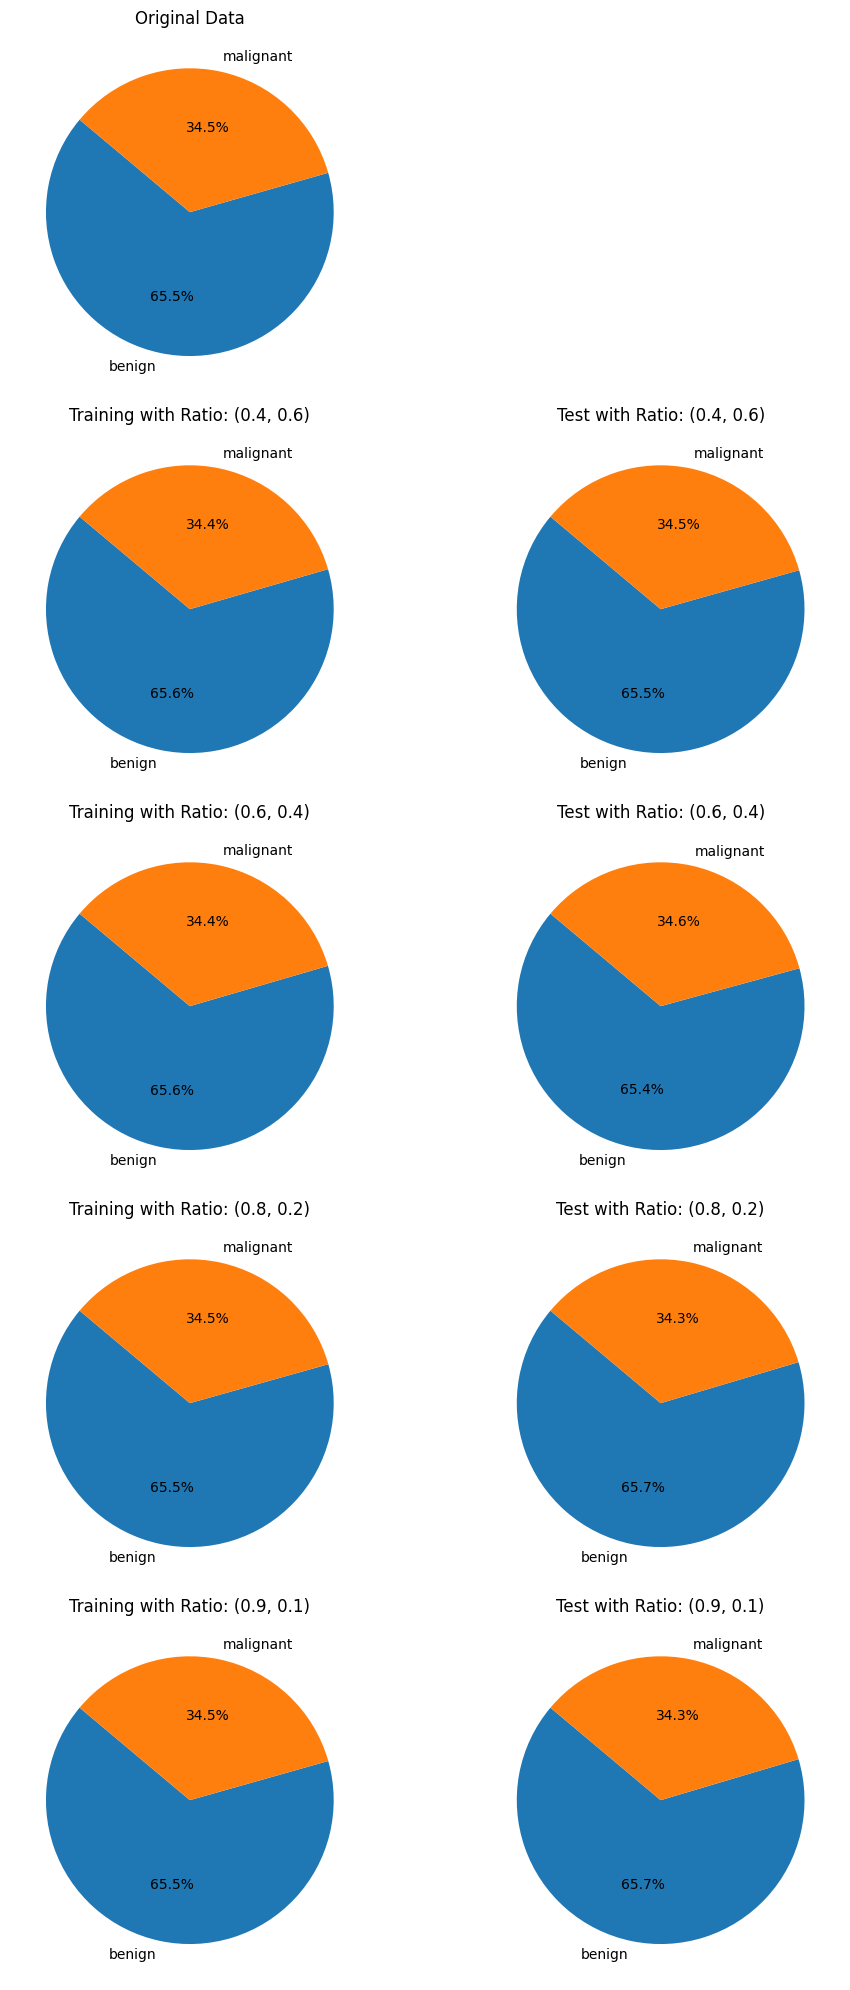

In [7]:
fig, ax = plt.subplots(5, 2, figsize=(10, 20))
# Vẽ dữ liệu gốc
counts_original = df_target[columns_target[0]].value_counts()
ax[0, 0].pie(counts_original,
             labels=['benign' if x == 2 else 'malignant' for x in counts_original.index],
             autopct='%1.1f%%',
             startangle=140)
ax[0, 0].set_title('Original Data')

ax[0, 1].remove()

# Vẽ các biểu đồ train/test cho từng tỷ lệ
for i, (ratio, d) in enumerate(data.items()):
    train_counts = d['y_train'][columns_target[0]].value_counts()
    test_counts = d['y_test'][columns_target[0]].value_counts()

    # Train plot
    ax[i + 1, 0].pie(train_counts,
                     labels=['benign' if x == 2 else 'malignant' for x in train_counts.index],
                     autopct='%1.1f%%',
                     startangle=140)
    ax[i + 1, 0].set_title(f'Training with Ratio: {ratio}')

    # Test plot
    ax[i + 1, 1].pie(test_counts,
                     labels=['benign' if x == 2 else 'malignant' for x in test_counts.index],
                     autopct='%1.1f%%',
                     startangle=140)
    ax[i + 1, 1].set_title(f'Test with Ratio: {ratio}')

plt.tight_layout()
plt.show()

# 2.2 Building the decision tree classifiers

In [30]:
def train_decision_tree(df_features, df_target, train_test_ratio, criterion="entropy", random_state=42):
    models = {}
    for train_ratio, test_ratio in train_test_ratio:
        X_train, X_test, y_train, y_test = train_test_split(
            df_features, df_target, test_size=test_ratio, random_state=random_state, stratify=df_target
        )
        # Huấn luyện mô hình
        clf = DecisionTreeClassifier(criterion=criterion, random_state=random_state)
        clf.fit(X_train, y_train)
        # Lưu kết quả vào dictionary
        models[(train_ratio, test_ratio)] = {
            'model': clf,
            'X_test': X_test,
            'y_test': y_test,
            'X_train': X_train,
            'y_train': y_train
        }
    return models

# 2.3 Evaluating the decision tree classifiers

In [32]:
def evaluate_decision_tree(models, df_features):
    results = {}
    for (train_ratio, test_ratio), data in models.items():
        clf = data['model']
        X_test = data['X_test']
        y_test = data['y_test']

        # Dự đoán
        y_pred = clf.predict(X_test)
        # Đánh giá
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, target_names=['Benign', 'Malignant'], digits=2)
        cm = confusion_matrix(y_test, y_pred)

        # Lưu kết quả
        results[(train_ratio, test_ratio)] = {
            'accuracy': accuracy,
            'report': report,
            'confusion_matrix': cm
        }

        # Hiển thị và lưu cây quyết định
        dot_data = export_graphviz(
            clf, out_file=None,
            feature_names=df_features.columns,
            class_names=['Benign', 'Malignant'],
            filled=True, rounded=True,
            special_characters=True
        )
        #Lưu cây qd
        graph = graphviz.Source(dot_data)
        filename = f"decision_tree_train{train_ratio}_test{test_ratio}"
        graph.render(filename, format='svg', cleanup=True)

        # Hiển thị classification report và ma trận nhầm lẫn
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # Classification report
        axes[0].axis('off')
        axes[0].text(0.5, 0.5, report, fontsize=10, va='center', ha='center', wrap=True)

        # Confusion matrix
        sns.heatmap(
            cm, annot=True, fmt='d', cmap='Reds', ax=axes[1],
            xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant']
        )
        axes[1].set_xlabel('Predicted')
        axes[1].set_ylabel('Actual')
        axes[1].set_title(f'Confusion Matrix (Train: {train_ratio}, Test: {test_ratio})')

        plt.tight_layout()
        plt.show()

    return results

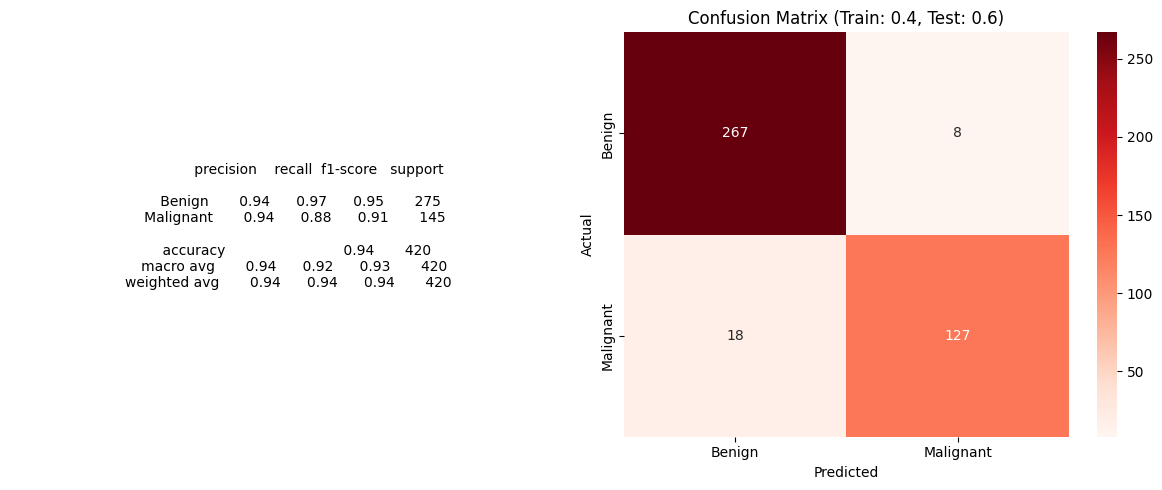

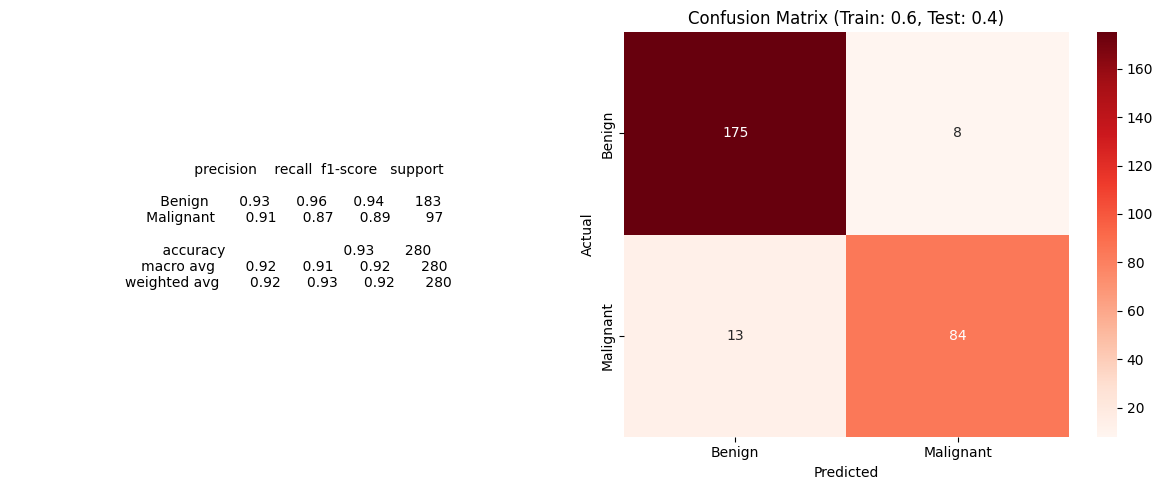

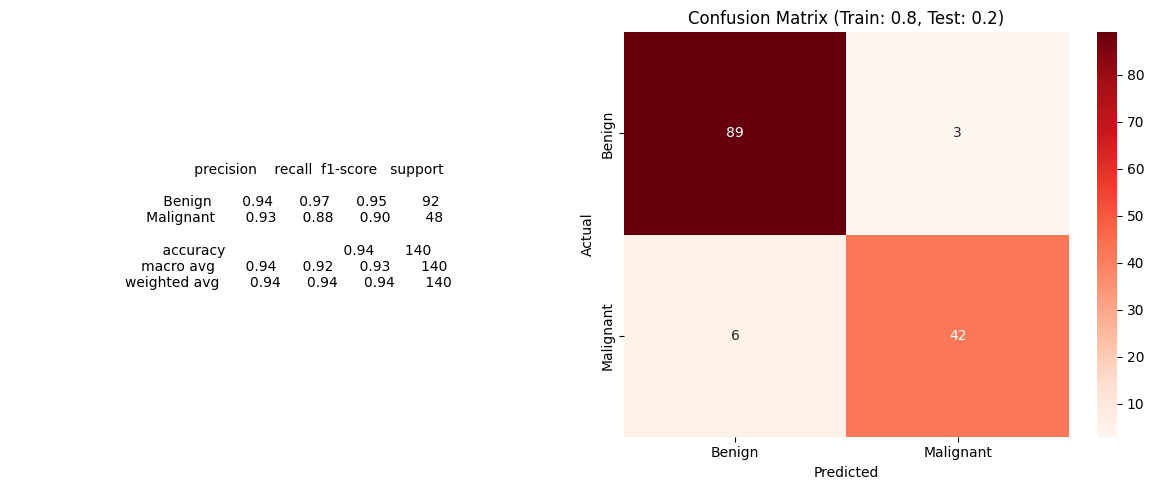

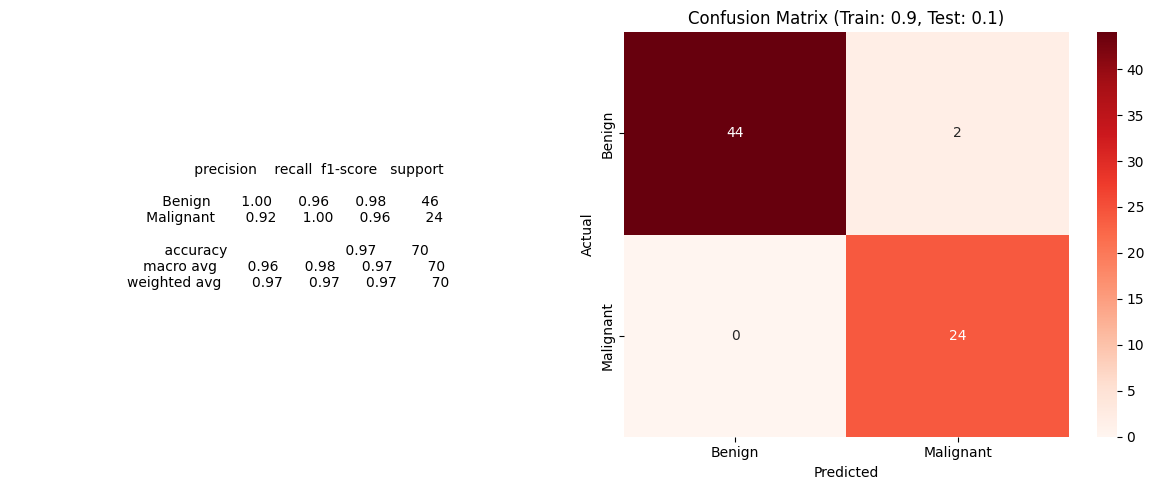

In [33]:
models = train_decision_tree(df_features, df_target, train_test_ratio)
results = evaluate_decision_tree(models, df_features)

# 2.4 The depth and accuracy of a decision tree

Độ sâu: None, Độ chính xác: 0.9500
Độ sâu: 2, Độ chính xác: 0.9357
Độ sâu: 3, Độ chính xác: 0.9214
Độ sâu: 4, Độ chính xác: 0.9286
Độ sâu: 5, Độ chính xác: 0.9429
Độ sâu: 6, Độ chính xác: 0.9429
Độ sâu: 7, Độ chính xác: 0.9429


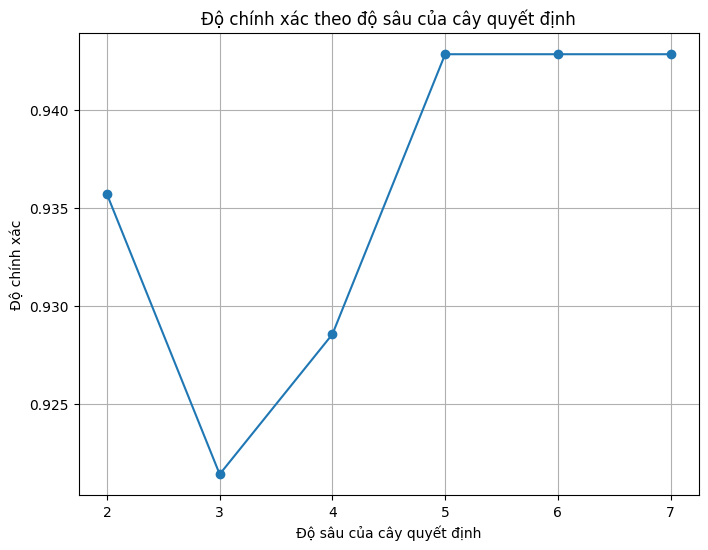

In [36]:
X_train, X_test, y_train, y_test = train_test_split(df_features, df_target, test_size=0.2, random_state=42, stratify=df_target)
depths = [None, 2, 3, 4, 5, 6, 7]
accuracies = []

for depth in depths:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    print(f"Độ sâu: {depth}, Độ chính xác: {accuracy:.4f}")

    # Trực quan hóa cây quyết định
    dot_data = export_graphviz(clf, out_file=None,
                               feature_names=df_features.columns,
                               class_names=['Benign', 'Malignant'],
                               filled=True, rounded=True,
                               special_characters=True)
    graph = graphviz.Source(dot_data)

    # Lưu cây quyết định với tên chứa độ sâu
    filename = f"decision_tree_depth_{depth}"
    graph.render(filename, format='svg', cleanup=True)

# Vẽ biểu đồ độ chính xác theo độ sâu
plt.figure(figsize=(8, 6))
plt.plot(depths, accuracies, marker='o')
plt.xlabel('Độ sâu của cây quyết định')
plt.ylabel('Độ chính xác')
plt.title('Độ chính xác theo độ sâu của cây quyết định')
plt.grid(True)
plt.show()
